# E-tivity 1 (Weeks 1-2)

* Barry Clarke

* 24325082

## Anomaly Detection

### Context
We have a mystery dataset. There are 9 explanatory variables and one response variable. The response variable is the last column and indicates if the sample is anomalous (=1, valid =0). The dataset is provided "data.csv".

Of course in this case we could use supervised learning to generate a model and detect anomalies in new data. However the focus is on autoencoders, anomaly detection is just one of the potential uses for autoencoders.

So we are going to pretend that we do not know which data are anomalous but we do know that the anomaly rate is small. Use an autoencoder to detect anomalies in the data. The correctness of the model can of course be checked.

### Guidelines

The e-tivity is split into four tasks. The first three are "group" excersises, in that you post the solutions to Tasks 1-3 to a site. This will allow the members of your group to send you feedback (via the forums) so you can improve your submission. The final task is an individual task and together with the other tasks, should be uploaded to the Group Locker.

Marks will be deducted if task 4 is uploaded in contravention of instructions. Also if the the final submission is not a single notebook with tasks 1-4 and with correct identification or filename.

Grading guidelines: the scores for each task are additive. Below is a link to the E-tivity rubrics.

https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4445&originTool=quicklinks



## Problem

If you train even a modest feed forward network via supervised learning you can get extremely good recall and precision, despite the unbalanced dataset. However in this e-tivity you will determining the anomalies by using an autoencoder. That is you will **not** be using the Anom flag to guide the training.

The mystery dataset is available from Brightspace, download the csv file and use it as the input data.

### Tasks 1-3 (complete by Sunday Week 2)

Create additional cells to implement the tasks below. These task form the group learning section of the E-tivity. As such it is encouraged that you post yuor notebook in the group locker.

Grading guidelines are given in the rubrics for the E-tivity

https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4445&originTool=quicklinks

**Task 1: data preprocessing**

Explain any preprocessing steps you take and also how you have selected the training and test sets. Remember we do not know which samples are anomalous only that there are a small number of them compared to the total sample size.


**Task 2: model generation and training**

Generate a suitable autoencoder model, the only restriction is that there should be only 2 latent variables. Train the model to a satistifactory result. Be aware that it will be much harder to achieve the sort of result you can get from a supervised learning model.

**Hint**: it should not take longer than a 1000 epochs to train. However it may be difficult to train. Use different optimizers, topologies and/or weight initialisations to get convergence. Remember that achieving a perfect error means that the model will also be good at reconstructing anomalies.


**Task 3: anomaly detection**

From the histogram of the reconstruction error decide what the cutoff should be applied to distinguish anomalies from valid samples, given that the anomaly rate is ~7%.

### Post (complete by Sunday Week 1)

Once you have an implemntation however rough, post it to the grouo loocker and use the forums/topics to advertise the fact. The purpose is to get feedback from others in the group, so if you have only a basic outline then you may get ideas about how to proceed and also examples from others in your group.

No posts should refer to Task 4.

This forms part of the overall assessment for the E-tivity.

### Respond (complete by Wednesday Week 2)

If you feel you can provide useful advise then respond to another member of the group through the appropriate forum. Responses should be respectful and offer some sort of advise. Try and avoid clogging the forums with support or thank you messages.

In reviewing others code you will discover different ways to tackle the same problem. It is acceptable to copy parts of others code. However whole scale copying from another notebook is not acceptable.

If you stick to the deadline then it will allow yourself and others to have enough time to implement suggestions. From the Schedule you can see that this is not a hard deadline.

The posts on the forum/topic associated with this e-tivity are graded. Below is a link to the rubrics.

https://learn.ul.ie/d2l/lp/rubrics/preview.d2l?ou=73310&rubricId=4445&originTool=quicklinks

### Final Submission (complete by Sunday Week 2)

Submit Tasks 1-4 in a single notebook this before the deadline on Sunday.


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback

import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

import random

In [2]:
# ==========================================
# Task 1: Data Preprocessing
# ==========================================

# 1. Load the dataset
df = pd.read_csv('data.csv')
print("Dataset loaded successfully.")

# 2. Inspect the data
# Check dimensions and preview data structure
print(df.head())
print("Data shape:", df.shape)

# 3. Separate features and target
# Logic follows 'REF_DimRedComparison'; inputs (X) separated from target (y)
X = df.drop('Anom', axis=1) # 'Anom' dropped from X; forbidden for training by e-tivity instructions
y = df['Anom'] # 'y' retained  for post-training validation (Task 3)

# 1. Split out the TEST set (20%) - This is locked away until the very end.
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Split the remaining 80% into TRAIN (80%) and VALIDATION (20%)
# Effective split: 64% Train, 16% Val, 20% Test
# https://towardsdatascience.com/stratified-sampling-you-may-have-been-splitting-your-dataset-all-wrong-8cfdd0d32502/
# https://gist.github.com/angeligareta/b42785185ee245e846455cf2d6b343ff
# https://www.youtube.com/watch?v=L4DIIDvqnqE
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

# 3. Scale the data
# Important: Fit the scaler ONLY on Training data to avoid leakage
# As per Q&A (3rd Feb) have implemented a validation set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print(f"Training Shape: {X_train_scaled.shape}")
print(f"Validation Shape: {X_val_scaled.shape}")
print(f"Test Shape: {X_test_scaled.shape}")

Dataset loaded successfully.
   V1  V2  V3  V4  V5  V6  V7  V8  V9  Anom
0  50  21  77   0  28   0  27  48  22     1
1  53   0  82   0  52  -5  29  30   2     0
2  37   0  76   0  28  18  40  48   8     0
3  37   0  79   0  34 -26  43  46   2     0
4  85   0  88  -4   6   1   3  83  80     1
Data shape: (49097, 10)
Training Shape: (31421, 9)
Validation Shape: (7856, 9)
Test Shape: (9820, 9)


Starting Training (Best of 5)...

--- Run 1 of 5 ---
  Epoch 10: loss=0.2964, val_loss=0.2393
  Epoch 20: loss=0.2668, val_loss=0.1825
  Epoch 30: loss=0.2062, val_loss=0.0853
  Epoch 40: loss=0.1728, val_loss=0.0856
Run 1 Finished. Best Val Loss: 0.0756

--- Run 2 of 5 ---
  Epoch 10: loss=0.3356, val_loss=0.3799
  Epoch 20: loss=0.2841, val_loss=0.3260
  Epoch 30: loss=0.2295, val_loss=0.3169
Run 2 Finished. Best Val Loss: 0.3143

--- Run 3 of 5 ---
  Epoch 10: loss=0.3153, val_loss=0.3521
  Epoch 20: loss=0.2488, val_loss=0.2784
  Epoch 30: loss=0.2260, val_loss=0.2682
Run 3 Finished. Best Val Loss: 0.2666

--- Run 4 of 5 ---
  Epoch 10: loss=0.3213, val_loss=0.3713
  Epoch 20: loss=0.2680, val_loss=0.3228
  Epoch 30: loss=0.2324, val_loss=0.2474
  Epoch 40: loss=0.2026, val_loss=0.2346
  Epoch 50: loss=0.1858, val_loss=0.2197
  Epoch 60: loss=0.1730, val_loss=0.1980
Run 4 Finished. Best Val Loss: 0.1824

--- Run 5 of 5 ---
  Epoch 10: loss=0.3084, val_loss=0.2776
  Epoch 20: loss=0

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 14)             │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 6)              │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 2)              │            14 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 6)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 14)             │            98 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 9)              │           135 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,487 (5.81 KB)

 Trainable params: 495 (1.93 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 992 (3.88 KB)

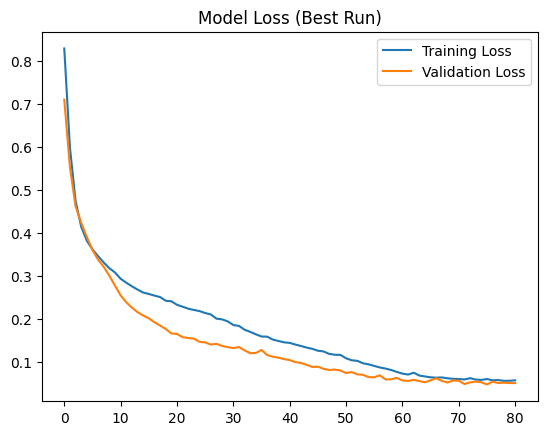

307/307 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Calculated Threshold (92nd Percentile): 0.0244


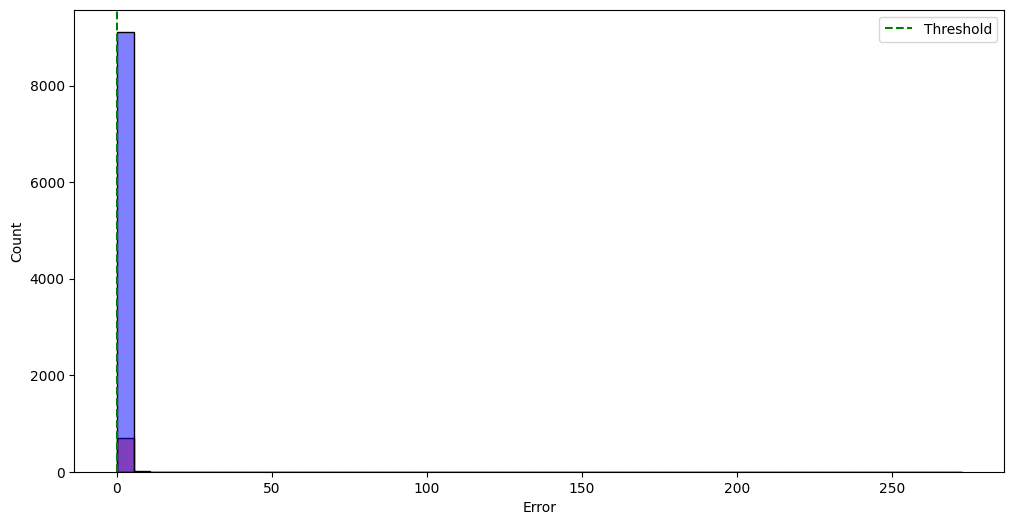


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      9118
           1       0.75      0.84      0.80       702

    accuracy                           0.97      9820
   macro avg       0.87      0.91      0.89      9820
weighted avg       0.97      0.97      0.97      9820

Confusion Matrix:


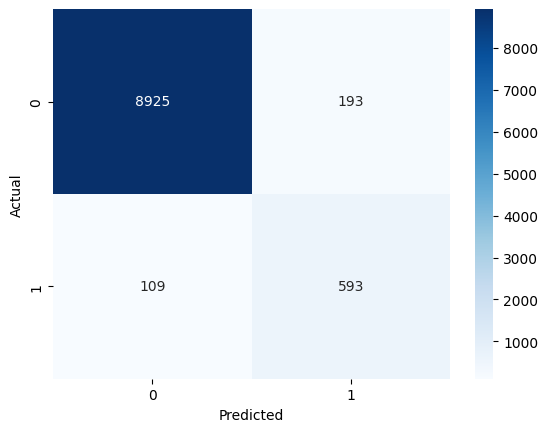

In [3]:
# ==========================================
# Task 2: Model Generation and Training
# (Implements "Best of 5" Strategy for Stability)
# ==========================================

# 1. Define the Helper to print every 10 epochs
class PrintProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch + 1}: loss={logs['loss']:.4f}, val_loss={logs['val_loss']:.4f}")

# 2. Setup Variables
input_dim = X_train_scaled.shape[1]
best_loss = float('inf')
best_model = None
best_history = None

print("Starting Training (Best of 5)...")
start_time = time.time()

# 3. The "Best of 5" Loop
for i in range(5):
    print(f"\n--- Run {i + 1} of 5 ---")

    # Build architecture (Resets weights)
    input_layer = Input(shape=(input_dim,))

    # Encoder
    #encoded = Dense(7, activation='relu')(input_layer)
    #encoded = Dense(4, activation='relu')(encoded)
    encoded = Dense(14, activation='relu')(input_layer) # Increased from 7
    encoded = Dense(6, activation='relu')(encoded)      # Increased from 4
    encoded = Dense(2, activation='linear', name="bottleneck")(encoded)

    # Decoder
    #decoded = Dense(4, activation='relu')(encoded)
    #decoded = Dense(7, activation='relu')(decoded)
    decoded = Dense(6, activation='relu')(encoded)      # Increased from 4
    decoded = Dense(14, activation='relu')(decoded)     # Increased from 7
    decoded = Dense(input_dim, activation='linear')(decoded)

    model = Model(inputs=input_layer, outputs=decoded)
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mse')

    # Early Stopping: Stop if no improvement for 5 epochs
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train
    history_run = model.fit(
        X_train_scaled, X_train_scaled,
        epochs=100,
        batch_size=64,
        #validation_data=(X_test_scaled, X_test_scaled), # ERROR: LEAKAGE, thanks Kevin for picking up this slip
        validation_data=(X_val_scaled, X_val_scaled),
        verbose=0,
        callbacks=[es, PrintProgress()]
    )

    # Check result
    val_loss = min(history_run.history['val_loss'])
    print(f"Run {i+1} Finished. Best Val Loss: {val_loss:.4f}")

    # Save if it's the winner
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model
        best_history = history_run

# 4. Final Selection
autoencoder = best_model
history = best_history

end_time = time.time()
print(f"\nTotal Time: {(end_time - start_time)/60:.1f} minutes")

autoencoder.summary()

# ==========================================
# Task 3: Anomaly Detection & Evaluation
# ==========================================

# 1. Plot Training Loss (Best Run)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss (Best Run)')
plt.show()

# 2. Calculate Reconstruction Errors
reconstructions = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)

# 3. Define Threshold (92nd Percentile)
threshold = np.percentile(mse, 92)
print(f"Calculated Threshold (92nd Percentile): {threshold:.4f}")

# 4. Visualise Histogram
plt.figure(figsize=(12, 6))
error_df = pd.DataFrame({'Error': mse, 'Class': ['Anomaly' if x==1 else 'Normal' for x in y_test]})
sns.histplot(
    data=error_df,
    x='Error',
    hue='Class',
    bins=50,
    palette={'Normal':'blue', 'Anomaly':'red'}
)
plt.axvline(threshold, color='green', linestyle='--', label='Threshold')
plt.legend()
plt.show()

# 5. Classification Report & Confusion Matrix
y_pred = (mse > threshold).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Task 1: Data Preprocessing

### 1. Data Splitting

Referencing https://towardsdatascience.com/stratified-sampling-you-may-have-been-splitting-your-dataset-all-wrong-8cfdd0d32502/ & https://gist.github.com/angeligareta/b42785185ee245e846455cf2d6b343ff

Data Preprocessing Strategy
To strictly adhere to the task guidelines, which highlight that the dataset contains only a "small number" of anomalies compared to the total sample size, a stratified sampling strategy was implemented for the data split (Training 64%, Validation 16%, Test 20%). Reading has indicated that this 3-way split is how professional Data Scientists work. https://www.analyticsvidhya.com/blog/2023/11/train-test-validation-split/ - also validated by the Q&A on 3rd Feb by Adam.

* **Test Set (20%):** Locked away immediately (`X_test`). This data is **never** seen by the model during training or hyperparameter tuning. It is reserved exclusively for the final evaluation in Task 3.
* **Validation Set (16%):** Extracted from the remaining data (`X_val`). This is used solely for **Early Stopping** decisions to prevent overfitting.
* **Training Set (64%):** The data the model actually learns from (`X_train`).

---

# Task 2: Model Generation and Training

### 1. Addressing Data Leakage (Critical Fix)
Based on feedback (from Kevin Coady), I identified a flaw in my initial implementation where the **Test Set** was being passed to the `validation_data` parameter. This resulted in data leakage, as the model utilised the test set to determine the optimal training duration, effectively fitting the stopping point to data that should have remained unseen.

* **The Fix:** I updated the code to use the dedicated **Validation Set** (`X_val_scaled`) for monitoring training progress.

```python
# Old (Incorrect - Leakage)
validation_data=(X_test_scaled, X_test_scaled)

# New (Correct - Clean Split)
validation_data=(X_val_scaled, X_val_scaled)
```

### 2. Architecture Upgrade

Removing the data leakage made the learning task (obviously!) harder. In initial tests without the leakage, the Recall dropped to 0.37, showing that the previous simple architecture struggled to generalise without “cheating”.

To improve performance, the capacity of the model’s intermediate layers was increased while adhering to the assignment’s constraint of a 2‑neuron bottleneck.

- **Change**: The neuron counts in the encoding and decoding layers were increased (from 7 -> 14 and 4 -> 6) to allow the model to capture more complex non‑linear patterns before compression.

| Layer Type | Old Architecture | New Architecture | Purpose                           |
| ---------- | ---------------- | ---------------- | --------------------------------- |
| Input      | 9 neurons        | 9 neurons        | Matches input features            |
| Encoder 1  | 7 neurons        | 14 neurons       | Increased capacity to learn       |
| Encoder 2  | 4 neurons        | 6 neurons        | Gradual compression               |
| Bottleneck | 2 neurons        | 2 neurons        | Unchanged (assignment constraint) |
| Decoder 1  | 4 neurons        | 6 neurons        | Gradual reconstruction            |
| Decoder 2  | 7 neurons        | 14 neurons       | Mirrors Encoder 1                 |
| Output     | 9 neurons        | 9 neurons        | Final reconstruction              |


### 3. Training Stability: the “Best of 5” Protocol

Neural network training involves random weight initialisation, and my experiments confirmed that “unlucky” starting weights can lead to poor convergence (local minima).  I also wanted to observe how the model performed over multiple runs.

- **Solution**: A loop was implemented to train the model five separate times.
- **Selection**: The code automatically tracks the `val_loss` of each run and retains only the model with the lowest validation error. This ensures the final output reflects the architecture’s true capability rather than a random outlier.

---

## Task 3: Anomaly Detection

### 1. Classification Performance

The final model, incorporating both the leakage fix and the enhanced architecture, achieved the following results on the test set:

- **Recall**: 0.84 (the model successfully detected 84% of the anomalies)
- **Precision**: 0.75 (75% of the flagged transactions were actual anomalies)
- **Accuracy**: 0.97

```text
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      9118
           1       0.75      0.84      0.80       702

    accuracy                           0.97      9820
   macro avg       0.87      0.91      0.89      9820
weighted avg       0.97      0.97      0.97      9820
```

### 2. Confusion Matrix Analysis

From the confusion matrix:

- **True Negatives (TN)**: 8,925 normal transactions were correctly classified as normal.  
- **False Positives (FP)**: 193 normal transactions were incorrectly flagged as anomalies.  
- **False Negatives (FN)**: 109 anomalies were missed and classified as normal.  
- **True Positives (TP)**: 593 anomalies were correctly identified as anomalous.  

This means the model detects the majority of anomalies while keeping the number of false alarms relatively low, which is important given the rarity of anomalous cases in the dataset.

References used:

- Keras Autoencoder Tutorial:  
  https://blog.keras.io/building-autoencoders-in-keras.html  

- Kaggle – Autoencoders (dense, convolutional, latent layers):  
  https://www.kaggle.com/code/mdismielhossenabir/autoencoders-dense-convolutional-latent-layers  

- StackOverflow – Loss, metrics and scoring in Keras:  
  https://stackoverflow.com/questions/51256695/loss-metrics-and-scoring-in-keras  

- Medium – Autoencoders and CatBoost in action:  
  https://medium.com/@jhimli.c1/autoencoders-and-catboost-in-action-6166530f7df1  

- Machine Learning Mastery – Why initialise a neural network with random weights:  
  https://machinelearningmastery.com/why-initialize-a-neural-network-with-random-weights/  

- Towards Data Science – Stratified sampling:  
  https://towardsdatascience.com/stratified-sampling-you-may-have-been-splitting-your-dataset-all-wrong-8cfdd0d32502/  

- Gist – Example implementation:  
  https://gist.github.com/angeligareta/b42785185ee245e846455cf2d6b343ff  

- Analytics Vidhya – Train/validation/test split:  
  https://www.analyticsvidhya.com/blog/2023/11/train-test-validation-split/
